<a href="https://colab.research.google.com/github/seungkyoon/Projects/blob/master/Bong_Seungkyoon_ps3_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSET 3
*CPSC 453: Unsupervised Learning*

*Seungkyoon Bong*

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/ColabNotebooks/
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/code')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ColabNotebooks


In [ ]:
from ps3_functions import *
from vae import VAE
import torch
from torchvision import datasets, transforms
import numpy as np
import torchvision.utils
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import time
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
from scipy.spatial.distance import cdist

# !pip install pyemd
# !pip install phate
# !pip install scprep
import phate
import scprep
from pyemd import emd

torch.manual_seed(1)

## 2 MNIST Classification

### 2.1 Downloading MNIST

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True,transform = transforms.ToTensor())

batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle = True)

### 2.2 Logistic Regression

In [ ]:
model = LogisticRegression()
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.5)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/log_reg.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.918233335018158. Test accuracy: 0.9202999472618103
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.92535001039505. Test accuracy: 0.9232999682426453
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9279833436012268. Test accuracy: 0.9236999750137329
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9288333654403687. Test accuracy: 0.9244999885559082
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9300833344459534. Test accuracy: 0.9264000058174133
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9306666851043701. Test accuracy: 0.9244999885559082
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9312666654586792. Test accuracy: 0.925599992275238
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9317666888237. Test accuracy: 0.926099956035614
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9324666857719421. Test accuracy: 0.925599992275238
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9331166744232178. Test accuracy: 0.9268999695777893


**Question 2.2.1:** *What percentage classification accuracy did your simple network achieve?*

**Answer:** After training for 100 epochs, my simple network achieved a test accuracy of ~92.7% (with a training accuracy of ~93.3%). This is quite impressive because the network is very simple with only a single layer of weights/biases directly connecting the inputs to outputs.


### 2.3 Feed-forward Neural Network

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9260333180427551. Test accuracy: 0.9228999614715576
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9298499822616577. Test accuracy: 0.9226999878883362
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9322167038917542. Test accuracy: 0.9253000020980835
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9334499835968018. Test accuracy: 0.9246000051498413
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9340833425521851. Test accuracy: 0.924299955368042
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9348000288009644. Test accuracy: 0.9261999726295471
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9358500242233276. Test accuracy: 0.9253999590873718
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.935283362865448. Test accuracy: 0.9241999983787537
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9361166954040527. Test accuracy: 0.9273999929428101
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9363999962806702. Test accuracy: 0.924299955368042


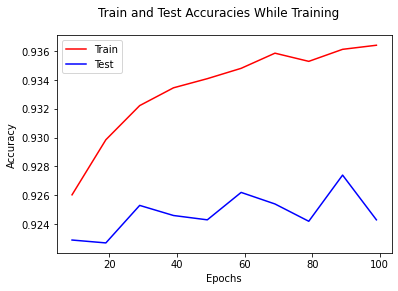

In [ ]:
# Without non-linearity
model = FeedForwardNet()
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_nonlinear.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.8874666690826416. Test accuracy: 0.8955999612808228
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9012500047683716. Test accuracy: 0.9083999991416931
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9089666604995728. Test accuracy: 0.9139999747276306
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9146833419799805. Test accuracy: 0.9185000061988831
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9196000099182129. Test accuracy: 0.9231999516487122
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9237333536148071. Test accuracy: 0.9261999726295471
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9270833730697632. Test accuracy: 0.929099977016449
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9296833276748657. Test accuracy: 0.930899977684021
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9325166940689087. Test accuracy: 0.9317999482154846
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9351500272750854. Test accuracy: 0.9339999556541443


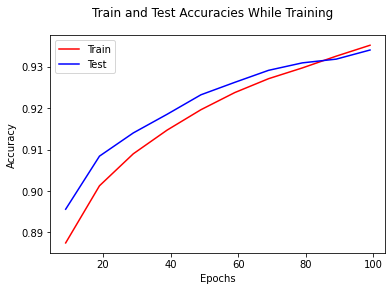

In [ ]:
# With sigmoid non-linearity before and after
# Likely cripples the model to have a nonlinearity in output (because cross entropy loss already takes softmax)
model = FeedForwardNet(pre_activation = nn.Sigmoid(), post_activation = nn.Sigmoid())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_sigmoid.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9308666586875916. Test accuracy: 0.9325999617576599
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.949483335018158. Test accuracy: 0.9470999836921692
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.960266649723053. Test accuracy: 0.9563999772071838
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9682833552360535. Test accuracy: 0.9624999761581421
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.974049985408783. Test accuracy: 0.9663999676704407
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9780166745185852. Test accuracy: 0.9697999954223633
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9811000227928162. Test accuracy: 0.9718999862670898
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9835500121116638. Test accuracy: 0.9738999605178833
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.98580002784729. Test accuracy: 0.9746999740600586
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9873499870300293. Test accuracy: 0.9761999845504761


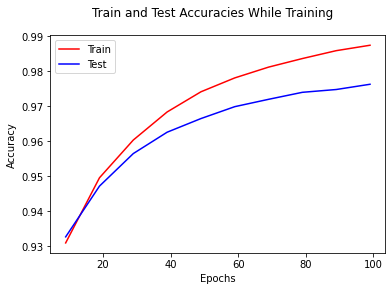

In [ ]:
# With sigmoid non-linearity before
model = FeedForwardNet(pre_activation = nn.Sigmoid())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_sigmoid_before.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9794166684150696. Test accuracy: 0.9708999991416931
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9902166724205017. Test accuracy: 0.9758999943733215
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9945999979972839. Test accuracy: 0.9772999882698059
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9970833659172058. Test accuracy: 0.9774999618530273
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9986833333969116. Test accuracy: 0.9791999459266663
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9994166493415833. Test accuracy: 0.9779999852180481
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9996500015258789. Test accuracy: 0.9781999588012695
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9998999834060669. Test accuracy: 0.9794999957084656
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9999666810035706. Test accuracy: 0.9790999889373779
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9999499917030334. Test accuracy: 0.979699969291687

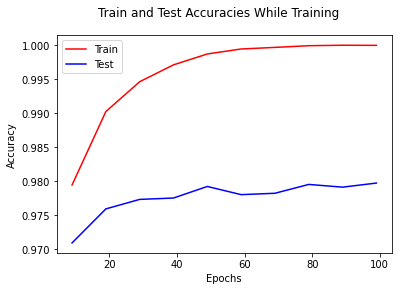

In [ ]:
# With ReLU non-linearity before <- BEST MODEL
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_relu.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9625000357627869. Test accuracy: 0.9587999582290649
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9775500297546387. Test accuracy: 0.9723999500274658
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9849500060081482. Test accuracy: 0.9751999974250793
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9885666966438293. Test accuracy: 0.9757999777793884
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9919500350952148. Test accuracy: 0.9768999814987183
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9950000047683716. Test accuracy: 0.9782999753952026
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9962166547775269. Test accuracy: 0.9784999489784241
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9971666932106018. Test accuracy: 0.9785999655723572
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9983167052268982. Test accuracy: 0.9788999557495117
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9990666508674622. Test accuracy: 0.978899955749511

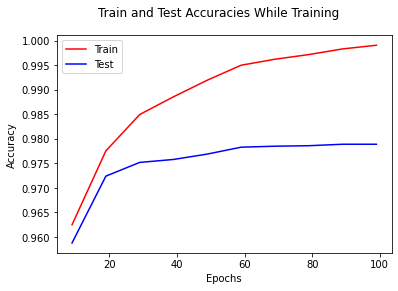

In [ ]:
# With Softplus non-linearity before
model = FeedForwardNet(pre_activation = nn.Softplus())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_softplus.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9606000185012817. Test accuracy: 0.9533999562263489
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9720500111579895. Test accuracy: 0.9634999632835388
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.977649986743927. Test accuracy: 0.9651999473571777
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9832000136375427. Test accuracy: 0.9690999984741211
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.985883355140686. Test accuracy: 0.9703999757766724
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9874666929244995. Test accuracy: 0.9698999524116516
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9901833534240723. Test accuracy: 0.9697999954223633
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9922333359718323. Test accuracy: 0.9699999690055847
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9932000041007996. Test accuracy: 0.9684999585151672
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9953333735466003. Test accuracy: 0.9698999524116516


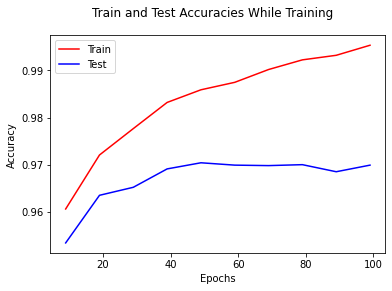

In [ ]:
# Best activation function (ReLU) non-linearity with smaller hidden size
model = FeedForwardNet(hidden_size = 30, pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_narrow.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.928600013256073. Test accuracy: 0.9305999875068665
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9451666474342346. Test accuracy: 0.9448999762535095
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9542833566665649. Test accuracy: 0.9524999856948853
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9612166881561279. Test accuracy: 0.9580000042915344
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9667500257492065. Test accuracy: 0.962399959564209
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9702333211898804. Test accuracy: 0.965499997138977
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9735167026519775. Test accuracy: 0.9680999517440796
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9761000275611877. Test accuracy: 0.9693999886512756
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9783833622932434. Test accuracy: 0.9715999960899353
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9806666970252991. Test accuracy: 0.972599983215332


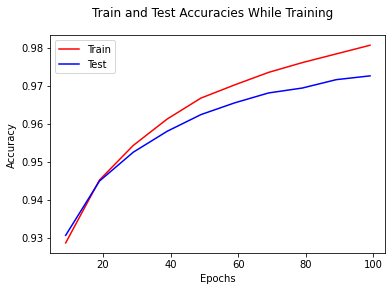

In [ ]:
# Best activation function (ReLU) non-linearity with lower learning rate
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_lr.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9958166480064392. Test accuracy: 0.9792999625205994
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.994616687297821. Test accuracy: 0.9768999814987183
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9963499903678894. Test accuracy: 0.9754999876022339
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9980166554450989. Test accuracy: 0.9782999753952026
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9970000386238098. Test accuracy: 0.975600004196167
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9988999962806702. Test accuracy: 0.979699969291687
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9987333416938782. Test accuracy: 0.9768999814987183
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9987666606903076. Test accuracy: 0.9782999753952026
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9988999962806702. Test accuracy: 0.9788999557495117
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9987500309944153. Test accuracy: 0.9795999526977539


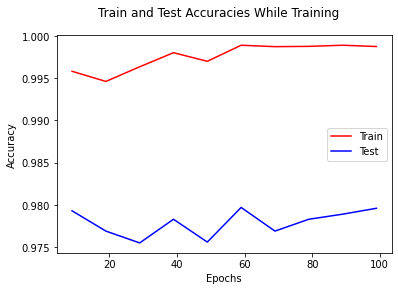

In [ ]:
# Best activation function (ReLU) non-linearity with Adam Optimizer
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 0.005)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_adam.pt')

In [ ]:
# Confusion Matrix for Best Model (ReLU)
from sklearn.metrics import confusion_matrix

classifier = FeedForwardNet(pre_activation = nn.ReLU()).to(device)
classifier.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ff_relu.pt'))
classifier.eval()

all_targets = []
all_outs = []
for data, targets in train_loader:
    targets = targets.to(device)
    model_input = torch.reshape(data, (-1, 784)).to(device)
    outs = classifier(model_input).argmax(dim=1).flatten()

    all_targets.extend(targets)
    all_outs.extend(outs)

for data, targets in test_loader:
    targets = targets.to(device)
    model_input = torch.reshape(data, (-1, 784)).to(device)
    outs = classifier(model_input).argmax(dim=1).flatten()

    all_targets.extend(targets)
    all_outs.extend(outs)

all_targets = list(map(int, all_targets))
all_outs = list(map(int, all_outs))
cm = confusion_matrix(all_targets, all_outs)
print(cm)

[[6896    0    2    0    0    0    1    1    2    1]
 [   0 7865    3    2    0    1    2    2    2    0]
 [   3    1 6969    2    2    0    4    4    5    0]
 [   0    0    7 7113    1    8    0    5    1    6]
 [   0    0    4    0 6805    0    3    3    1    8]
 [   4    0    0    6    1 6286    8    1    3    4]
 [   2    3    1    1    6    5 6855    1    2    0]
 [   1    4    4    4    1    0    0 7270    4    5]
 [   4    0    1    5    3    0    4    4 6800    4]
 [   3    2    0    4    7    2    0    3    2 6935]]


In [ ]:
# Most misclassified numbers
print(np.sum(cm, axis=1) - np.diagonal(cm))

[ 7 12 21 28 19 27 21 23 25 23]


Activation (Before Hidden Layer) | Activation (After Hidden Layer) | LR | Optimizer | Hidden Size | Train Accuracy | Test Accuracy
--- | --- | --- | --- | --- | --- | ---
Linear (Identity) | Linear (Identity) | 0.05 | SGD | 128 | 93.64% | 92.43%
Sigmoid | Sigmoid | 0.1 | SGD | 128 | 93.52% | 93.40%
Sigmoid | Linear (Identity) | 0.1 | SGD | 128 | 98.73% | 97.62%
ReLU | Linear (Identity) | 0.1 | SGD | 128 | **99.99%** | **97.97%**
Softplus | Linear (Identity) | 0.1 | SGD | 128 | 99.91% | 97.89%
ReLU | Linear (Identity) | 0.1 | SGD | 30 | 99.53% | 96.99%
ReLU | Linear (Identity) | 0.01 | SGD | 128 | 98.07% | 97.26%
ReLU | Linear (Identity) | 0.001 | Adam | 128 | 99.88% | 97.96%

**Question 2.3.1:** *What percentage classification accuracy does this more complex network achieve?*

**Answer:** The best of these models (the first ReLU model) achieves a test accuracy of nearly 98% (97.97%) which is very impressive and hard to do much better than because some of the MNIST training samples are hard to differentiate even with human perception. Moreover, many of the other models with the same architecture but different non-linearity before the hidden layer achieves very similar accuracy.

**Question 2.3.2:** *Create a plot of the training and test error vs the number of iterations. How many iterations
are sufficient to reach good performance?*

**Answer:** While it depends on many factors (e.g. model architecture, learning rate, optimizer), it appears that most models are able to reach good performance (close to the highest test accuracy) in around 50 epochs. For example, the best model (with ReLU) was able to achieve 97.9% test accuracy by epoch 50; it was even able to achieve 99% train accuracy by epoch 20 although the test accuracy is still able to increase slightly. Similarly, the model with softplus was able to achieve 97.8% test accuracy by epoch 60. However, there are exceptions to these trends (e.g. ReLU with lower learning rate, ReLU with Adam optimizer) that take less or more epochs to reach good performance (discussed further in question 2.3.4). Also, it is interesting to note that the test accuracy increases quite steadily with respect to the number of epochs for most models which indicates that the train set is likely representative of the train set; this is also why with a model like the one with ReLU, even when the train accuracy hits 99% (when the model should be overfitting), the test accuracy continues to increase.

Note: I plotted accuracy instead of error (which is 1-accuracy) but the insights are the same.

**Question 2.3.3:** *Print the confusion matrix showing which digits were misclassified, and what they were misclassified as. What numbers are frequently confused with one another by your model?*

**Answer:** I printed out the confusion matrix for the best model (ReLU) to see which numbers even the best model had difficultly correctly predicting. From the matrix, it appears that the number that was misclassified the most was 3 (which was mistaken most frequently as 2 and 5) which makes sense to me as 3 and 2 look quite similar and 5 is very close to a 3 (with a small line moved from the left to the right side of the number). 5 was misclassified second most frequently, being mistaken as a 6 most often. This also makes sense because a 5 with a nearly closed loop will look very similar to a 6. On the other hand, it appears that the number 0 was mistaken least often which makes sense to me as it is the most distinct shape (with no lines in the center of the number that could be mistaken for another number unlike most of the others).

**Question 2.3.4:** *Experiment with the learning rate, optimizer and activation function of your network. Report the best accuracy and briefly describe the training scheme that reached this accuracy.*

**Answer:** From the chart above, we can see the performance of the feed forward network with various different configurations. First, I started with no non-linearity (and had to decrease learning rate to 0.05) which achieved a test accuracy of 92.43% which is actually worse than the logistic regression model from part 2.2. Then, to experiment with non-linearities, I added a sigmoid activation function before and after the hidden layer (and increased learning rate to 0.1) and found that the test accuracy was only 93.4%. The poor performance is likely because the model is being crippled by adding a non-linearity to the output because the categorical cross-entropy loss already performs the softmax operation for us to transform the output to an optimal format for classification. The sigmoid will compress the output of the model in the range of (0, 1) which willl not perform well with the implicit softmax in `torch.nn.CrossEntropyLoss()`.

Reverting the activation function of the output to a linear function, I experimented with the other activation function using sigmoid, ReLU, and softplus. I found that these models had quite comparable performances with test accuracies near 98% (ReLU did best by a small margin). This was very impressive and hard to do much better than because some digits are difficult to classify even with human eyes. This demonstrates that nonlinear activation functions are generally preferred to learn more complex, non-linear structures found in the data (albeit not always as demonstrated with the double sigmoid activation neural network).

Finally, using the best activation function (ReLU), I modified the hidden size, learning rate, and optimizer. First, reducing the hidden size from 128 to 30, the model was still able to achieve over 99% accuracy but only about 97% test accuracy. This is likely because there are too few hidden nodes, making it possible to overfit the training data but not learn quite as many of the complexities in the underlying data (and thus slightly underperforming on the unseen test set). Then, by lowering the learning rate from 0.1 to 0.01, the model is unable to converge to the same ~98% test accuracy, only reaching a 97% test accuracy that was still increasing after 100 epochs. This is unsurprising as this simply indicates that the learning rate was set too low to converge quickly enough. Finally, I experimented with changing the SGD optimizer to the Adam optimizer which was able to achieve similar ~98% test accuracy of its SGD counterpart. However, it was interesting to note that the Adam optimizer actually had a near 98% test accuracy from epoch 10. This matches my previous experience using the Adam optimizer because it is very fast and can achieve very high accuracy quickly (often quicker than SGD).

## 3 Autoencoder

### 3.1 MNIST

In [ ]:
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:

            # run the model on the data
            model_input = torch.reshape(data, (-1, 784)).to(device)
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # Give status reports every 5 epochs
        if (epoch + 1) % 5==0:
            print(f" EPOCH {epoch+1}. Progress: {(epoch+1)/num_epochs*100}%. ")
            print(f" Train loss: {evaluate(model,train_loader)}. Test loss: {evaluate(model,test_loader)}")

def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the MSE loss of the output and original input
    """
    total_loss = 0
    total_samples = 0
    loss_fn = torch.nn.MSELoss()

    with torch.no_grad():
        for data, targets in evaluation_set:

            model_input = torch.reshape(data, (-1, 784)).to(device)
            out = model(model_input)

            total_samples += targets.shape[0]
            total_loss += loss_fn(out, model_input)*targets.shape[0]

    mean_loss = 1.0 * total_loss / total_samples
    return mean_loss

In [ ]:
# Bad/worse model using tanh activation (the other autoencoder is used for analysis)
model = Autoencoder(activation = nn.Tanh())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_tanh.pt')

 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.03971928358078003. Test loss: 0.039753977209329605
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.03825227543711662. Test loss: 0.03825204819440842
 EPOCH 15. Progress: 15.0%. 
 Train loss: 0.03697613999247551. Test loss: 0.03711700811982155
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.03632295876741409. Test loss: 0.03646008297801018
 EPOCH 25. Progress: 25.0%. 
 Train loss: 0.035278987139463425. Test loss: 0.03563898056745529
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.03516751900315285. Test loss: 0.03558137267827988
 EPOCH 35. Progress: 35.0%. 
 Train loss: 0.03494458273053169. Test loss: 0.03547857701778412
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.03503577411174774. Test loss: 0.03564044088125229
 EPOCH 45. Progress: 45.0%. 
 Train loss: 0.03483179211616516. Test loss: 0.03520921617746353
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.03463738411664963. Test loss: 0.03501656651496887
 EPOCH 55. Progress: 55.00000000000001%. 
 Train loss: 0.034

In [ ]:
# Display 1000 samples from latent space with corresponding label
def display_1000(model, out_size = 2, extra_hidden = None, extra_targets = None):
    all_outs = np.empty((0, out_size))
    all_targets = []

    total_displayed = 0
    for data, targets in test_loader:
      model_input = torch.reshape(data, (-1, 784))
      
      if model.__class__.__name__ == "VAE":
          out = model.encode(model_input)[0].detach().numpy()
      else:
          out = model.encode(model_input).detach().numpy()

      all_outs = np.vstack((all_outs, out))
      all_targets.extend(list(map(int, targets)))
      
      total_displayed += targets.shape[0]
      if total_displayed >= 1000:
        break

    outs = all_outs
    if model.__class__.__name__ == "VAE":
        phate_op = phate.PHATE(verbose=0)
        outs = phate_op.fit_transform(all_outs)
        if (extra_hidden is not None and extra_targets is not None):
            extra_hidden = phate_op.transform(extra_hidden)

    ax = scprep.plot.scatter2d(outs, c = all_targets, legend = True, legend_loc = 'right', discrete=True,
                          figsize=(12, 8), cmap=scprep.plot.colors.tab10_continuous(n_colors=10))
    ax.set_title("Embedding Layer of Autoencoder for 1000 Images")
    
    if extra_hidden is not None and extra_targets is not None:
      ax.scatter(extra_hidden[0:2, 0], extra_hidden[0:2, 1], c=extra_targets, marker='x',
                s=300, cmap=scprep.plot.colors.tab10_continuous(n_colors=10),
                          vmin=0, vmax=9)
      ax.scatter(extra_hidden[2, 0], extra_hidden[2, 1], c='red', marker='x', s=300)
      ax.set_title(f"Plot with Interpolated {extra_targets[0]}-{extra_targets[1]} In Red")
  

# Display 10 reconstructed digits
def display_10(model):
  total_displayed = [False]*10
  plt.figure(figsize=(20, 4))
  for data, targets in test_loader:
    model_input = torch.reshape(data, (-1, 784))

    if model.__class__.__name__ == "VAE":
        out = model(model_input)[0].detach().numpy()
    else:
        out = model(model_input).detach().numpy()
    out = out.reshape(-1, 28, 28)

    for i, target in enumerate(targets):
      if not total_displayed[target]:
        plt.subplot(2, 10, target + 1)
        plt.axis('off')
        plt.imshow(data[i, :, :].reshape(28, 28), aspect='auto')

        plt.subplot(2, 10, target + 11)
        plt.axis('off')
        plt.imshow(out[i, :, :].reshape(28, 28), aspect='auto')

        total_displayed[target] = True
    
    if not any(total_displayed):
      break
    
  plt.show()

# Interpolate a point between two existing points
def interpolate(model):
  plt.figure(figsize=(12, 4))
  for data, targets in test_loader:
    if targets[0] == targets[[1]]: continue
    model_input = torch.reshape(data[0:2, :, :], (-1, 784))
    out = model.encode(model_input)
    if model.__class__.__name__ == "VAE":
        mu, logvar = out
    
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title(f'Original {targets[0]}')
    plt.imshow(data[0, :, :].reshape(28, 28), aspect = 'auto')

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title(f'Original {targets[1]}')
    plt.imshow(data[1, :, :].reshape(28, 28), aspect = 'auto')
    
    if model.__class__.__name__ == "VAE":
        mu_mean = mu.mean(dim=0)
        logvar_mean = logvar.mean(dim=0)
        interpolated = model.reparameterize(mu_mean, logvar_mean)
    else:
        interpolated = out.mean(dim=0)

    output = model.decode(interpolated).detach().numpy().reshape(28, 28)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title(f'Interpolated {targets[0]}-{targets[1]}')
    plt.imshow(output, aspect = 'auto')

    break

  plt.show()

  targets = [targets[0], targets[1]]
  if model.__class__.__name__ == "VAE":
      out = torch.vstack((mu, mu_mean)).detach().numpy()
  else:
      out = torch.vstack((out, interpolated)).detach().numpy()

  display_1000(model, out_size = out.shape[1], extra_hidden = out, extra_targets = targets)


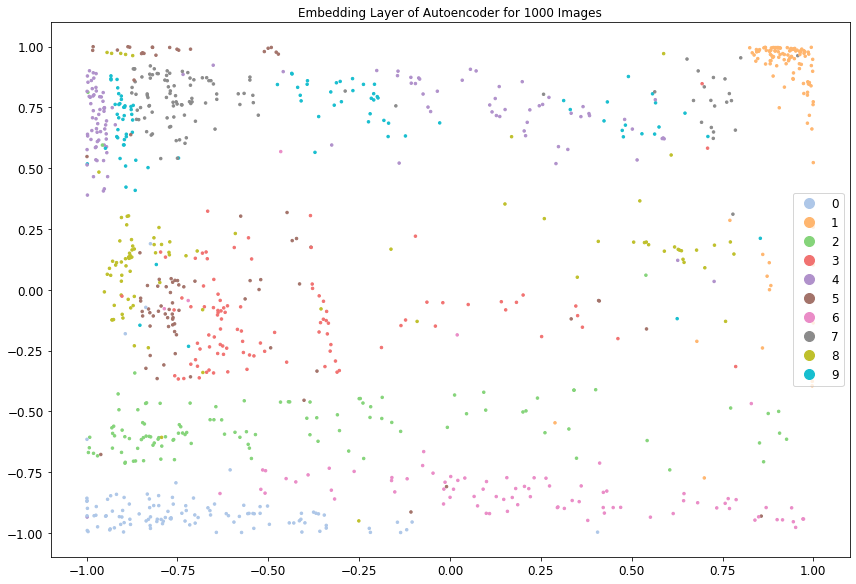

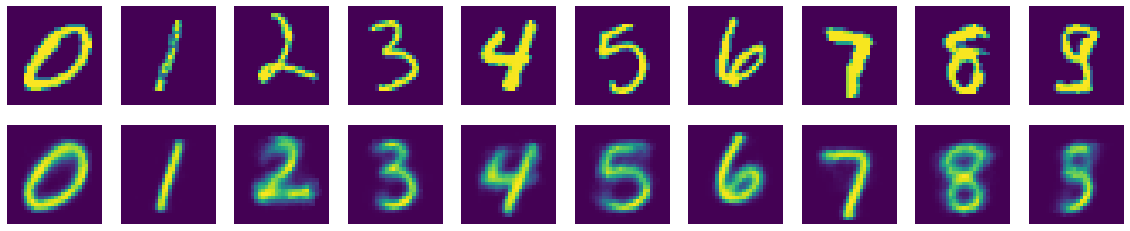

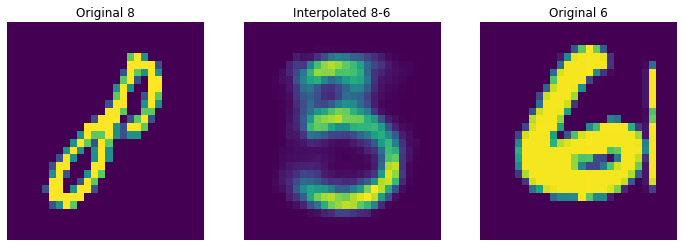

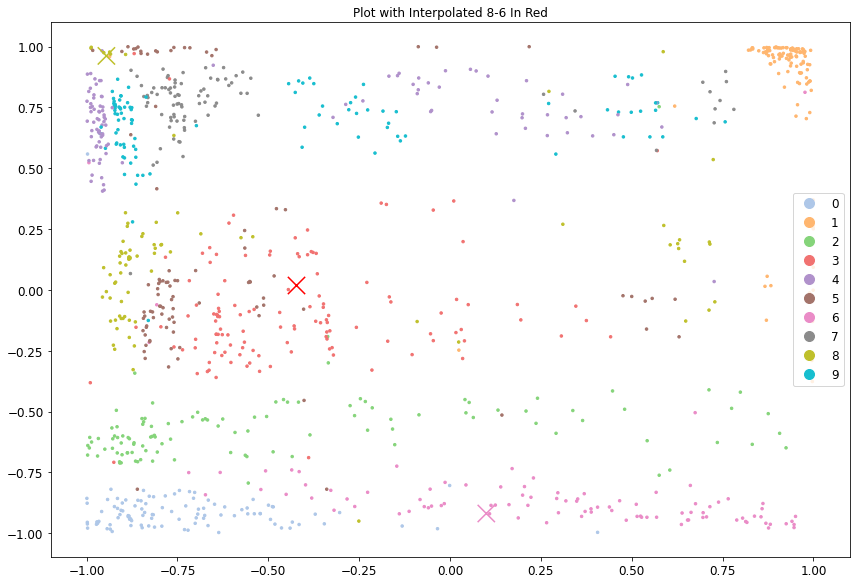

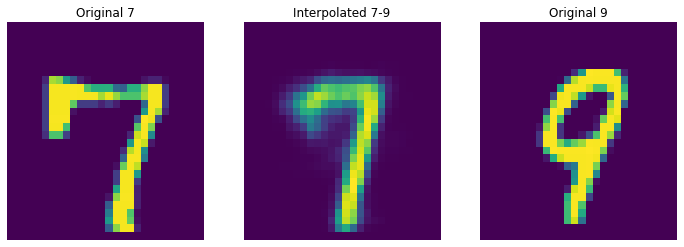

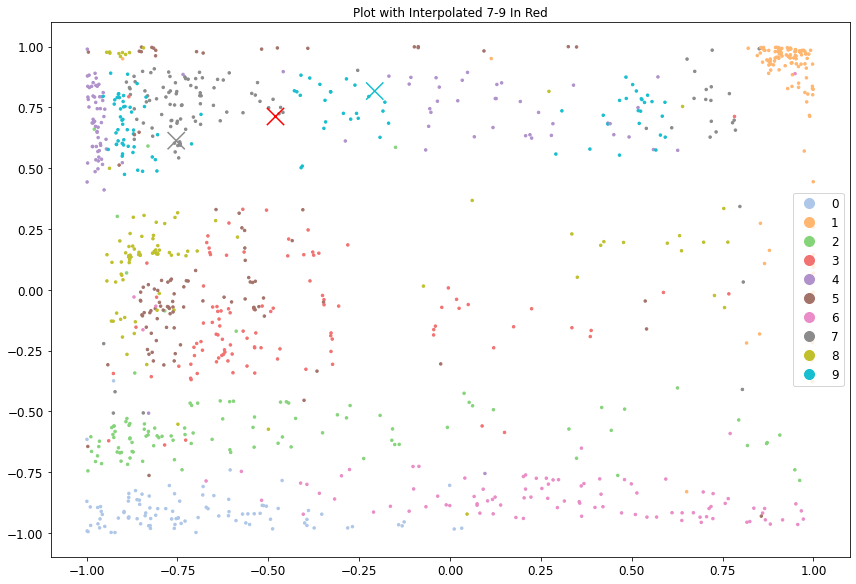

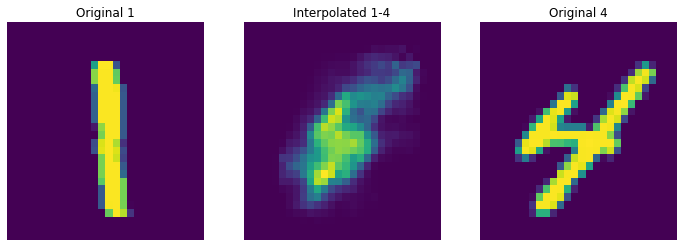

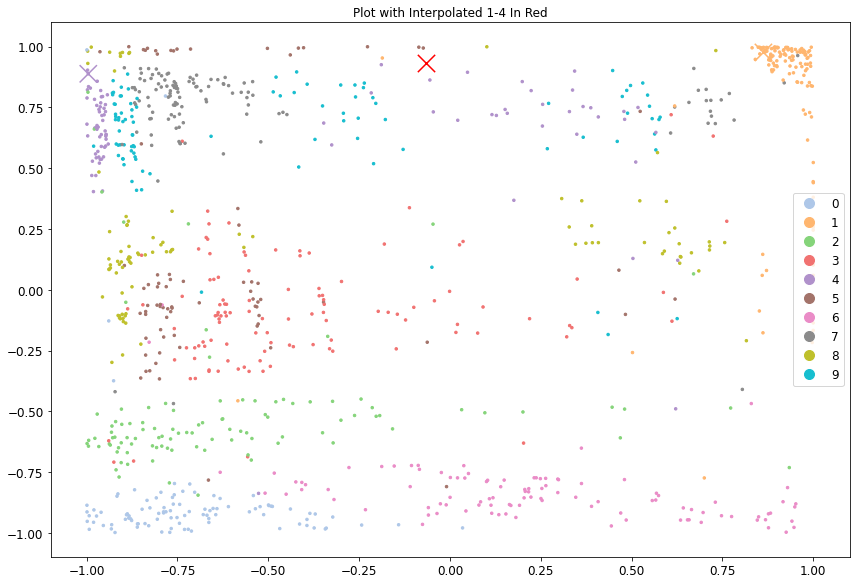

In [ ]:
# Bad/worse model using tanh activation (the other autoencoder is used for analysis)
model = Autoencoder(activation = nn.Tanh())
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_tanh.pt'))
model.eval()

display_1000(model)
display_10(model)

for i in range(3):
  interpolate(model)

In [ ]:
# Model without nonlinearity (tanh) going to middle layer is better
# Analysis of autoencoder will be done with respect to this model
model = Autoencoder()
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_identity.pt')

 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.03961634635925293. Test loss: 0.0399719662964344
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.036376673728227615. Test loss: 0.037006065249443054
 EPOCH 15. Progress: 15.0%. 
 Train loss: 0.035099174827337265. Test loss: 0.035776104778051376
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.03458607196807861. Test loss: 0.03539487347006798
 EPOCH 25. Progress: 25.0%. 
 Train loss: 0.034379735589027405. Test loss: 0.035191748291254044
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.033789992332458496. Test loss: 0.034768685698509216
 EPOCH 35. Progress: 35.0%. 
 Train loss: 0.033441927284002304. Test loss: 0.03448091819882393
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.032894037663936615. Test loss: 0.03393232822418213
 EPOCH 45. Progress: 45.0%. 
 Train loss: 0.03251643851399422. Test loss: 0.03377606347203255
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.032349176704883575. Test loss: 0.03374491631984711
 EPOCH 55. Progress: 55.00000000000001%. 
 Train los

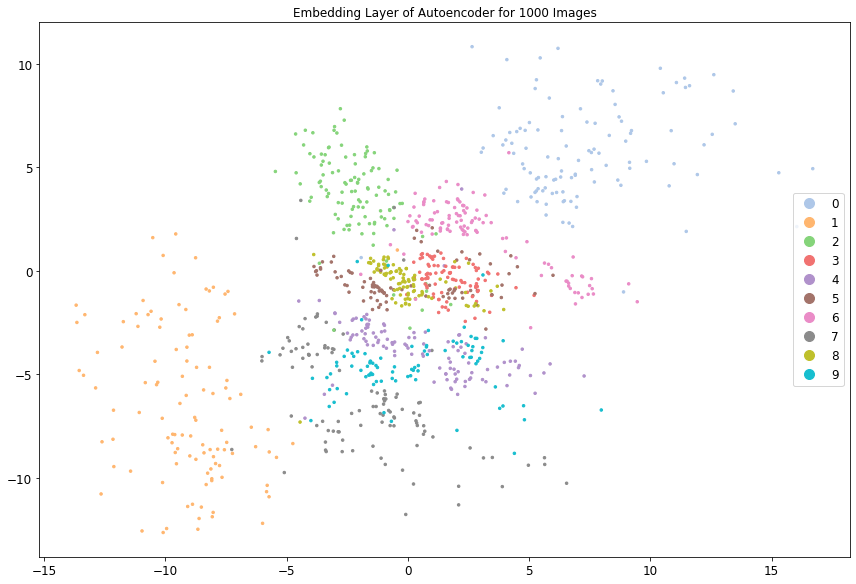

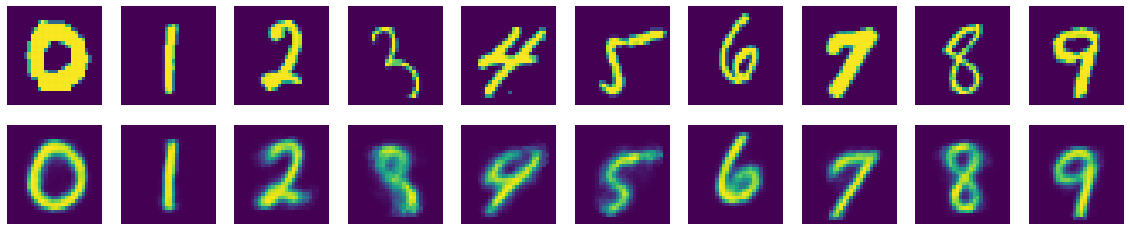

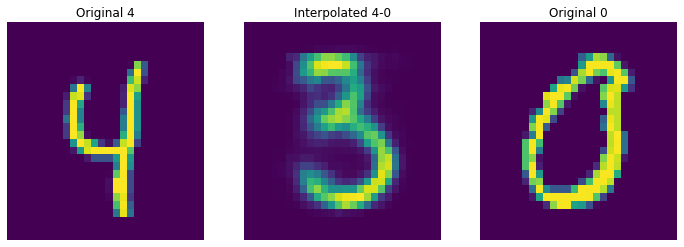

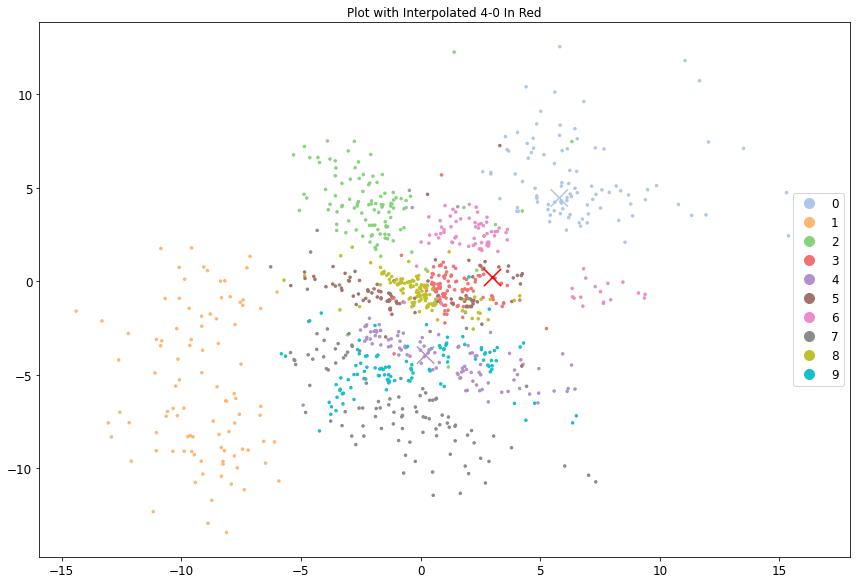

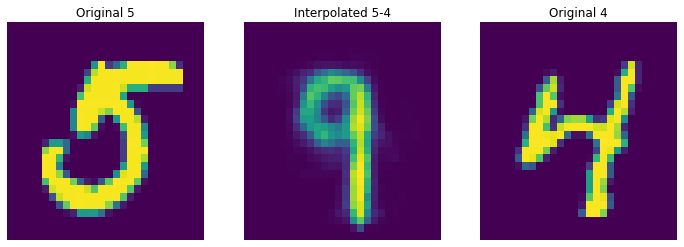

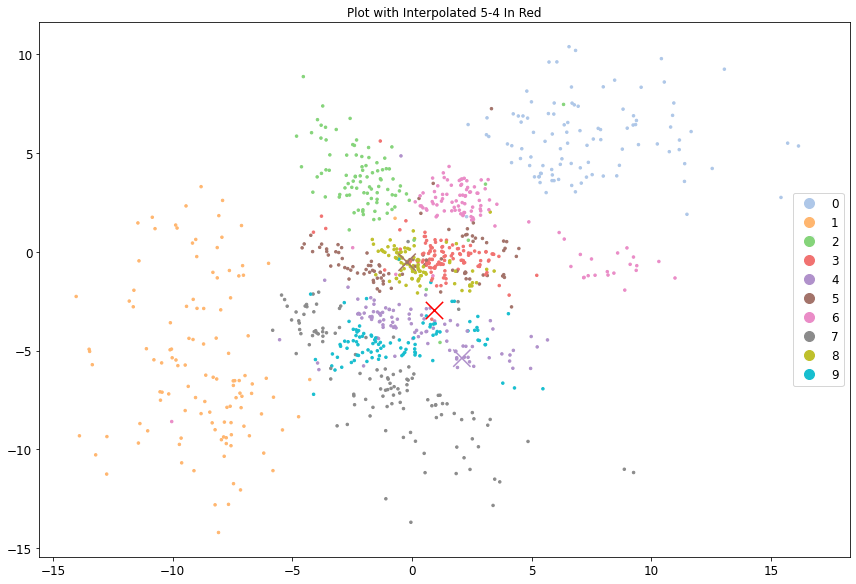

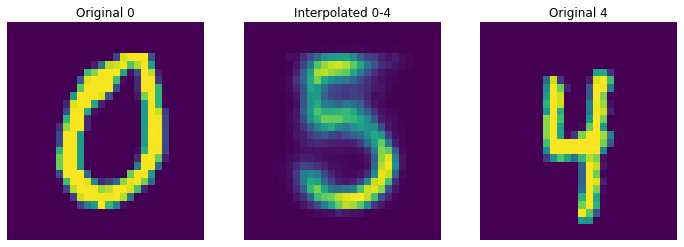

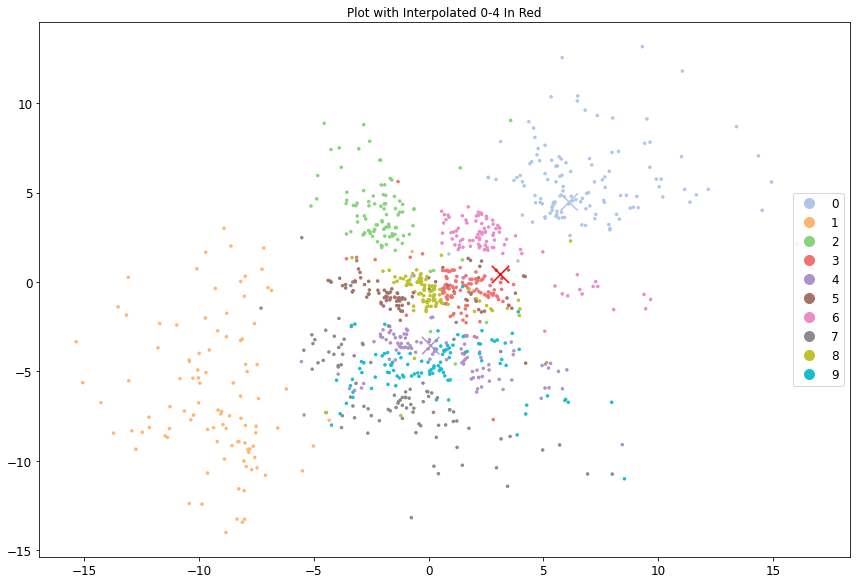

In [ ]:
# Model without nonlinearity (tanh) going to middle layer is better
# Analysis of autoencoder will be done with respect to this model
model = Autoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_identity.pt'))
model.eval()

display_1000(model)
display_10(model)

for i in range(3):
  interpolate(model)

**Question 3.1.1:** *Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?*

**Answer:** Although some of the clusters of numbers around the edges of the embedding space above are more easily separable from the rest (e.g. 1, 0), a majority of the numbers are clustered in the middle of the embedding space around (0, 0). Even some of the numbers that are packed together in the middle of the embedding space are still more easily separarable than others (e.g. 2 and 6 appear to have more distinct clusters than numbers like 5 which can be found in the same space as 3 and 8). In addition, there are cluster like 9 and 4 which appear to be overlapping. When numbers are close in the latent space, it would typically signify that these numbers are more similar which I think is the case here (e.g. 9 and 4 are quite similar with one small line differentiating them). This is corroborated by other neighboring clusters like 7 and 9 (a 7 is kind of like a 9 missing part of its loop), 0 and 6 (a 6 can be trimmed down to a 0), and 1 and 7 (a 7 has an extra line to a typical 1).

**Question 3.1.2:** *How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?*

**Answer:** All of the generated interpolated images above were surprisingly quite realistic (i.e. a classifier would likely be able to detect all three examples above as a 3, 9, and 5). In addition, looking at the 9 that was interpolated from 5 and 4, I would believe that the 9 is "in between" the 5 and the 4 (e.g. imagine taking the shape of the 4 and closing off the top using the top line of the 5). On the other hand, the other two interpolations don't necessarily make sense (e.g. 4 & 0 seem quite different from 3 and 0 & 4 seem quite different from 5). This may be partially due to the interpolations being between farther points in the embedding space when compared to the 5-9-4 example. In addition, in a traditional autoencoder, the latent space is not inherently designed to be interpolable so it makes sense that the generated image does not necessarily have to be a "combination" of the two images.

To generate new images with an autoencoder, we could take the decoding component of the autoencoder and pass in points from the embedding space and see what images are generated. We have reasonable proof that this would work because all three generated numbers above (regardless of the "accuracy" of the interpolation) appear approximately in the cluster of its corresponding number indicating that new numbers could likely be generated by sampling a point in the approximate cluster/number of interest.

### 3.2 Biological Data: Retinal Bipolar Dataset

In [ ]:
import pandas
import scprep
from sklearn.model_selection import train_test_split
data = pandas.read_pickle('/content/drive/MyDrive/ColabNotebooks/data/retinal-bipolar-data.pickle')
metadata = pandas.read_pickle('/content/drive/MyDrive/ColabNotebooks/data/retinal-bipolar-metadata.pickle')
data_pca = scprep.reduce.pca(data, 1024)

n_samples = 20000
data_sub, metadata_sub = scprep.select.subsample(data_pca, metadata, n=n_samples, seed=1)
data_sub = np.array(data_sub, dtype=np.float32)
metadata_sub = np.array(metadata_sub)

data_train, data_test, meta_train, meta_test = train_test_split(data_sub, metadata_sub,
                                          test_size=0.2, random_state=1, shuffle=True)

batch_size = 100
rbd_train_loader = torch.utils.data.DataLoader(data_train, batch_size, shuffle = True)
rbd_test_loader = torch.utils.data.DataLoader(data_test, batch_size, shuffle = True)

In [ ]:
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data in train_loader:

            # run the model on the data
            model_input = data.to(device)
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # Give status reports every 10 epochs
        if (epoch + 1) % 10==0:
            print(f" EPOCH {epoch+1}. Progress: {(epoch+1)/num_epochs*100}%. ")
            print(f" Train loss: {evaluate(model,train_loader)}. Test loss: {evaluate(model,test_loader)}")

def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the MSE loss of the output and original input
    """
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data in evaluation_set:

            model_input = data.to(device)
            out = model(model_input)

            total_samples += data.shape[0]
            total_loss += loss_fn(out, model_input)*data.shape[0]

    mean_loss = 1.0 * total_loss / total_samples
    return mean_loss
            
model = Autoencoder(sizes=[1024, 512, 256, 128, 2], post_activation = nn.Identity())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, rbd_train_loader, rbd_test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_bipolar.pt')

 EPOCH 10. Progress: 10.0%. 
 Train loss: 2.9391303062438965. Test loss: 2.9613189697265625
 EPOCH 20. Progress: 20.0%. 
 Train loss: 2.9032368659973145. Test loss: 2.932337522506714
 EPOCH 30. Progress: 30.0%. 
 Train loss: 2.8874735832214355. Test loss: 2.927443027496338
 EPOCH 40. Progress: 40.0%. 
 Train loss: 2.875368595123291. Test loss: 2.9199588298797607
 EPOCH 50. Progress: 50.0%. 
 Train loss: 2.8675856590270996. Test loss: 2.9194681644439697
 EPOCH 60. Progress: 60.0%. 
 Train loss: 2.8624868392944336. Test loss: 2.919577121734619
 EPOCH 70. Progress: 70.0%. 
 Train loss: 2.868588924407959. Test loss: 2.9246015548706055
 EPOCH 80. Progress: 80.0%. 
 Train loss: 2.8567006587982178. Test loss: 2.922710657119751
 EPOCH 90. Progress: 90.0%. 
 Train loss: 2.8551230430603027. Test loss: 2.9256434440612793
 EPOCH 100. Progress: 100.0%. 
 Train loss: 2.8623411655426025. Test loss: 2.929213762283325


Text(0.5, 1.0, 'Embedding Layer of Retinal Bipolar Autoencoder for 2000 Cases')

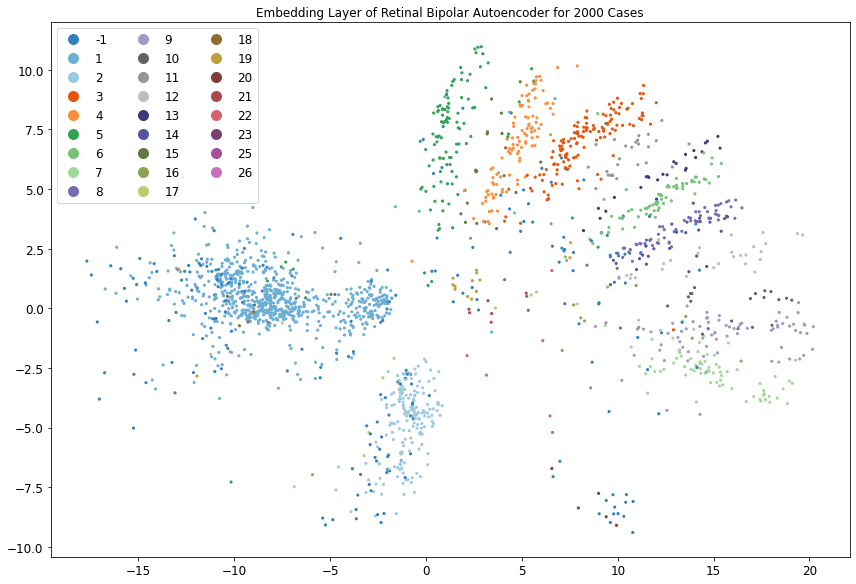

In [ ]:
# Modification of display_1000 code above
model = Autoencoder(sizes=[1024, 512, 256, 128, 2], post_activation = nn.Identity())
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_bipolar.pt'))
model.eval()

all_outs = np.empty((0, 2))
all_targets = []
total_displayed = 0
for i in range(20):
  model_input = torch.tensor(data_test[100*i:100*(i+1), :])
  targets = meta_test[100*i:100*(i+1), 0]
  out = model.encode(model_input).detach().numpy()

  all_outs = np.vstack((all_outs, out))
  all_targets.extend(list(map(int, targets)))
  
  total_displayed += targets.shape[0]

ax = scprep.plot.scatter2d(all_outs, c = all_targets, legend = True, discrete=True,
                      figsize=(12, 8), cmap=scprep.plot.colors.tab30())
ax.set_title(f"Embedding Layer of Retinal Bipolar Autoencoder for {total_displayed} Cases")

**Question 3.2.1:** *How many clusters are visible in the embedding? Do they correspond to the cluster labels?*

**Answer:** Based on the visualization it appears that there are at least 10 clusters present. More importantly, these clusters appear to roughly correspond to (smaller groups of) the colors/labels from the "cluster" column of the metadata. It is quite impressive that so many clusters are quite visible, especially when considering that the bottleneck of the autoencoder only has dimension 2. However, this autoencoder is incapable of capturing the 26 true clusters because 2 dimensions is not sufficient to capture the high dimensional, complex structure of this retinal bipolar data. This is why several labels (e.g. -1, 1, 2) appear to highly overlap and there are no clear boundaries between the true cluster labels in the visualization. These overlapping labels thus likely represent groupings of the retinal bipolar data that are inherently more similar to each other than from data points with embeddings in disjoint clusters.

## 4 Generative Models

### 4.1 The Variational Autoencoder

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks
!python code/vae.py --epochs 100 --log-interval 500

/content/drive/MyDrive/ColabNotebooks
Train Epoch: 1 [0/60000 (0%)]	Loss: 185.038010
====> Epoch: 1 Average loss: 45.1896
====> Test set loss: 36.3585
Train Epoch: 2 [0/60000 (0%)]	Loss: 34.148956
====> Epoch: 2 Average loss: 34.9674
====> Test set loss: 33.4418
Train Epoch: 3 [0/60000 (0%)]	Loss: 33.405102
====> Epoch: 3 Average loss: 33.1410
====> Test set loss: 32.2883
Train Epoch: 4 [0/60000 (0%)]	Loss: 32.802277
====> Epoch: 4 Average loss: 32.2361
====> Test set loss: 31.5511
Train Epoch: 5 [0/60000 (0%)]	Loss: 32.284492
====> Epoch: 5 Average loss: 31.7202
====> Test set loss: 31.2097
Train Epoch: 6 [0/60000 (0%)]	Loss: 32.989441
====> Epoch: 6 Average loss: 31.3635
====> Test set loss: 30.8546
Train Epoch: 7 [0/60000 (0%)]	Loss: 30.950377
====> Epoch: 7 Average loss: 31.0903
====> Test set loss: 30.8190
Train Epoch: 8 [0/60000 (0%)]	Loss: 31.083160
====> Epoch: 8 Average loss: 30.8980
====> Test set loss: 30.5422
Train Epoch: 9 [0/60000 (0%)]	Loss: 31.747532
====> Epoch: 9 Aver

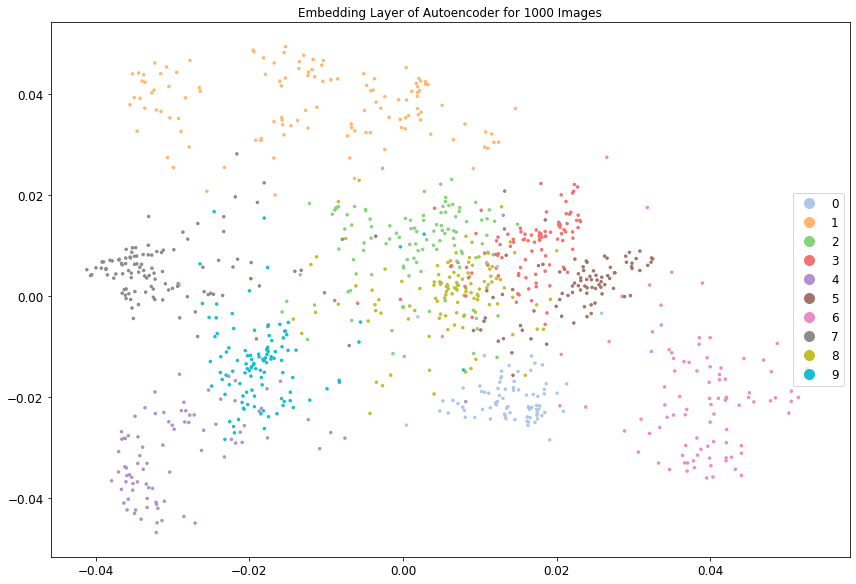

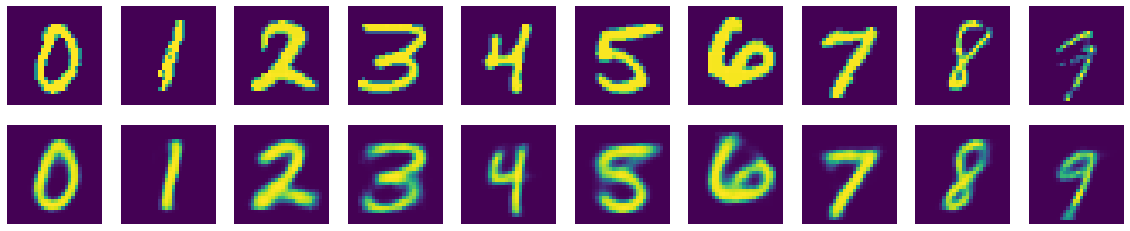

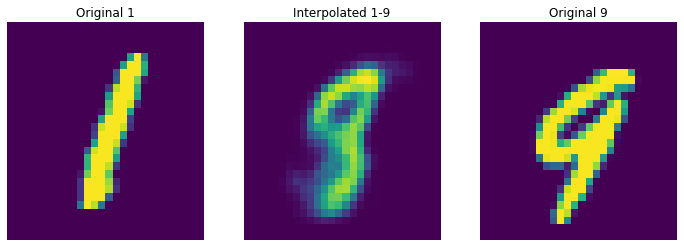

/usr/local/lib/python3.6/dist-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


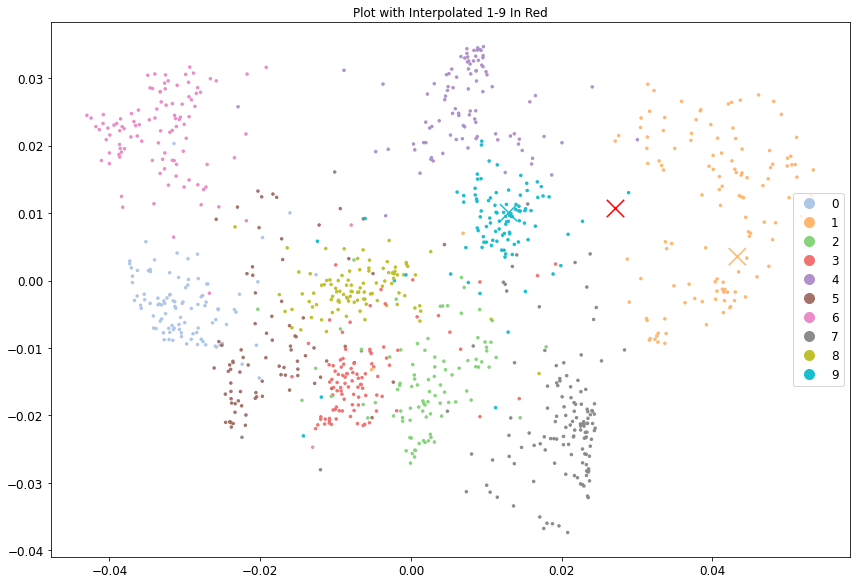

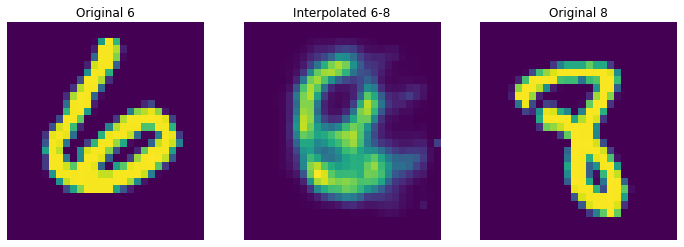

/usr/local/lib/python3.6/dist-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


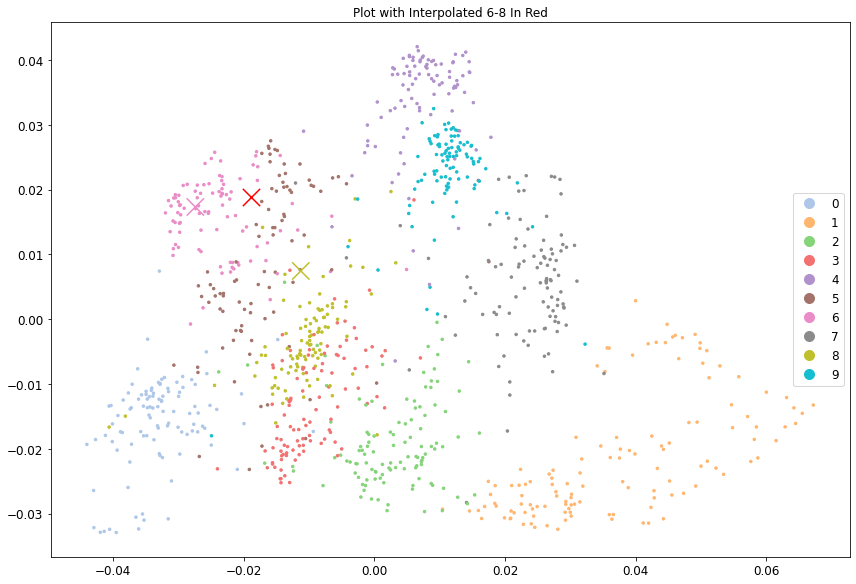

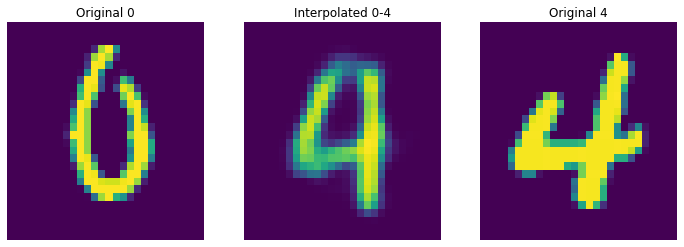

/usr/local/lib/python3.6/dist-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


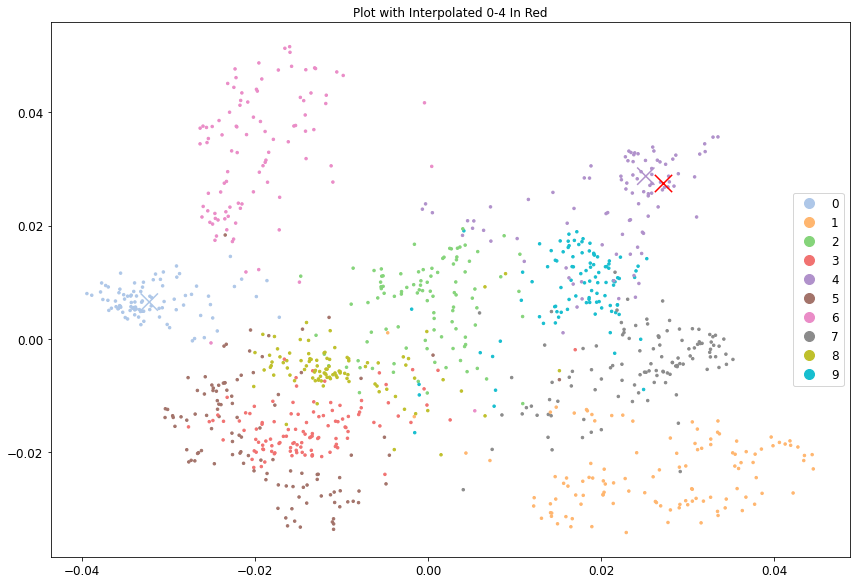

In [ ]:
model = torch.load('/content/drive/MyDrive/ColabNotebooks/vae.pt')
model = model.to("cpu")

display_1000(model, out_size = 20)
display_10(model)

for i in range(3):
    interpolate(model)

**Question 4.1.1:** *How does the VAE’s latent space compare to the latent space of your previous autoencoder? Do the generated images have more clarity? Is this most noticeable between or within classes?*

**Answer:** The visualizations of the VAE's latent space was created by running PHATE on the 20-dimensional mu vector generated from the encoding component of the VAE. This is why each visualization will look slightly different as the PHATE embeddings will depend on the data points and also why the interpolated point's embedding will not necessarily be between the two original points' embeddings (PHATE is non-linear). The latent space, as expected, appears to be better at separating different number labels and stops points from overlapping in the embdding space. It also has fewer empty regions, instead spreading out the embeddings of the 10 clusters to better cover the latent space and allow for better interpolability. This makes sense due to the interplay of the reconstruction loss (create good clusters representing each type of number) and the KL-divergence (encourage each cluster to be similar/close) which thus allows for better interpolability in this latent space.

In general, the generated images do not look as clear as those from the vanilla autoencoder. I believe that this is because the VAE introduces a noise (variance of the probability distribution in the embedding) which makes the VAE output not as crisp as those from the autoencoder that does not include any random noise. However, the interpolation of 0 and 4 to create another 4 was quite realistic, likely because the interpolated point was closer to the 4s in the embedding space (appears to be true based on the proximity of the generated image to the 4 in the latent space). The other two interpolated images (1-9 and 6-8) do not create crisp results, although I believe that the interpolated image incorprorates aspects of both numbers (e.g. 1 & 9 create a number a that looks like a 9 except skinnier and 6 & 8 create a number that looks like an 8 morphed into the shape of a 6. I believe that the VAE also may not have created clear interpolated images because there were many dimensions and the interpolated point (especially if it is interpolated from two points that were initially far apart) may not have ended up near an existing cluster.

**Question 4.1.2:** *In what situations would a VAE be more useful than a vanilla autoencoder, and when would you prefer a vanilla autoencoder to a VAE?*

**Answer:** In general, a VAE is useful to create new instances which autoencoders are not as good at. For example, we can't simply draw a random embedding from the AE latent space because we have no restrictions on the shape of this latent space. On the other hand, VAE is easier to draw from to create new samples because we have the reconstruction loss and KL-divergence to allow for interpolability of the latent space which allows for better generation of images. In general, an autoencoder would better for dimensionality reduction and other techiques where you want to preserve as much data as possible. In the VAE, the gaussian probability distribution around the encoded point is not ideal for dimensionality reduction because it will introduce a noise that can diminish the amount of information that the autoencoder can learn about the structure in the data. In addition, autoencoders are likely create crisper images so it can be feasible to generate images using an autoencoder if the sole goal is to create realistic images and the latent space is known and specific points can be picked based on the known locations of clusters.

**Question 4.1.3:** *The distance between embeddings in your first autoencoder provided some measure of the similarity between digits. To what extent is this preserved, or improved, by the VAE?*

**Answer:** Looking at the plots above, it appears that many of the same observations of the proximity of clusters in the latent space of the autoencoder apply for the variational autoencoder. For example, in the VAE latent space it appears that the 6 and 0 are close (6 is like a 0 with an extra line), 4 and 9 are close (4 is like a 9 without the top part of the loop), and 7 and 9 are close (7 is like 9 without the bottom/left of the loop). In fact, I would argue that the new embedding space is better because there are some clusters that are closer now than they were in the autoencoder latent space that make sense; for example, 0 and 8 are close in the new latent space (0 is like an 8 without the middle line) whereas they were not in the autoencoder latent space. This is again likely because the VAE has an improved latent space with explicit constraints on its shape that would better encourage similar numbers to be clustered closer together in the compressed 20-dimensional latent space.

### 4.2 GANs

In [ ]:
# nz=100
!python code/GAN.py

Epoch 0: mean discriminator loss 0.3963082432746887 // mean generator loss 1.4960644245147705
Epoch 1: mean discriminator loss 0.31417977809906006 // mean generator loss 1.6973217725753784
Epoch 2: mean discriminator loss 0.30743810534477234 // mean generator loss 1.6736215353012085
Epoch 3: mean discriminator loss 0.29308784008026123 // mean generator loss 1.6119202375411987
Epoch 4: mean discriminator loss 0.2723456919193268 // mean generator loss 1.5827842950820923
Epoch 5: mean discriminator loss 0.302641361951828 // mean generator loss 1.4504163265228271
Epoch 6: mean discriminator loss 0.31861451268196106 // mean generator loss 1.3450078964233398
Epoch 7: mean discriminator loss 0.3265911340713501 // mean generator loss 1.3358896970748901
Epoch 8: mean discriminator loss 0.324595183134079 // mean generator loss 1.3386613130569458
Epoch 9: mean discriminator loss 0.31453433632850647 // mean generator loss 1.3653758764266968
Epoch 10: mean discriminator loss 0.30280208587646484 // 

In [ ]:
# nz=25
!python code/GAN.py

Epoch 0: mean discriminator loss 0.4289831519126892 // mean generator loss 1.4224261045455933
Epoch 1: mean discriminator loss 0.38948744535446167 // mean generator loss 1.4830061197280884
Epoch 2: mean discriminator loss 0.33901429176330566 // mean generator loss 1.4941326379776
Epoch 3: mean discriminator loss 0.30918049812316895 // mean generator loss 1.5174927711486816
Epoch 4: mean discriminator loss 0.3451070189476013 // mean generator loss 1.3223142623901367
Epoch 5: mean discriminator loss 0.35682201385498047 // mean generator loss 1.2649003267288208
Epoch 6: mean discriminator loss 0.34560438990592957 // mean generator loss 1.2531505823135376
Epoch 7: mean discriminator loss 0.34246331453323364 // mean generator loss 1.2490540742874146
Epoch 8: mean discriminator loss 0.33268243074417114 // mean generator loss 1.2941964864730835
Epoch 9: mean discriminator loss 0.32107803225517273 // mean generator loss 1.3215296268463135
Epoch 10: mean discriminator loss 0.3104863464832306 //

Counts of 1000 Classified Numbers: {0: 638, 1: 0, 2: 14, 3: 150, 4: 2, 5: 64, 6: 19, 7: 3, 8: 98, 9: 12}
20 Random Numbers


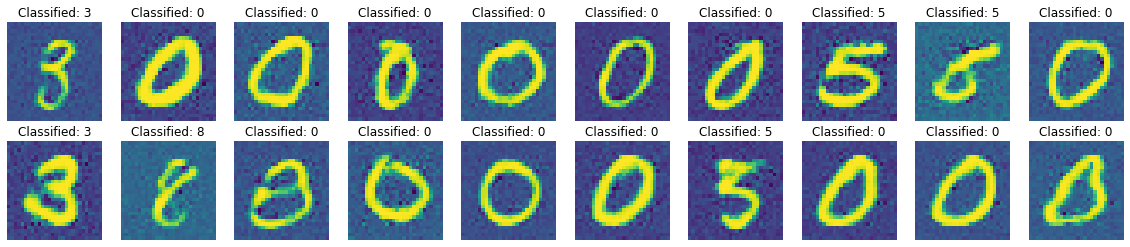

2 of Each Number Generated


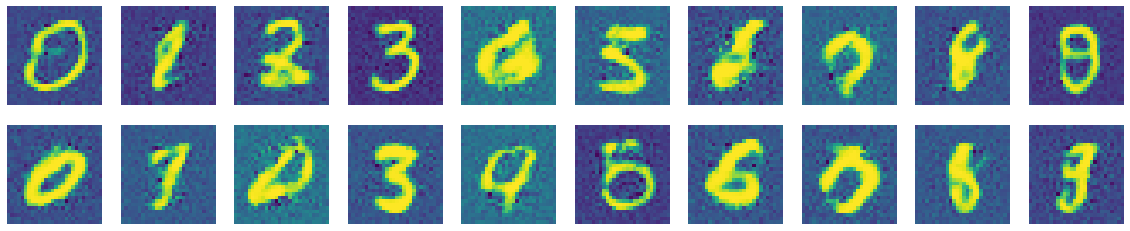

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Generator with nz=100
generator = torch.load('/content/drive/MyDrive/ColabNotebooks/gan_2.pt')
generator.eval()

# Best classifier from part 2 (ReLU non-linearity)
classifier = FeedForwardNet(pre_activation = nn.ReLU())
classifier.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ff_relu.pt',
                                      map_location=torch.device('cpu')))

torch.manual_seed(2)
counts = torch.zeros(10)
for i in range(10):
    fake_data = generator(torch.randn(100, 100)).reshape(-1, 784)
    labels = classifier(fake_data).argmax(dim=1)
    out, count = torch.unique(labels, sorted=True, return_counts=True)
    for i, label in enumerate(out):
        counts[label] += count[i]

count_dict = {}
for i in range(10):
    count_dict[i] = int(counts[i])
print("Counts of 1000 Classified Numbers:", count_dict)

# Modified from display_10 function above
torch.manual_seed(1)
fake_data = generator(torch.randn(20, 100)).reshape(-1, 784)
reshaped = fake_data.reshape(-1, 28, 28).detach().numpy()
labels = classifier(fake_data).argmax(dim=1)

print("20 Random Numbers")
plt.figure(figsize=(20, 4))
for i, label in enumerate(labels):
    ax = plt.subplot(2, 10, i + 1)
    ax.title.set_text(f"Classified: {label}")
    plt.axis('off')
    plt.imshow(reshaped[i, :, :], aspect='auto')
  
plt.show()


print("2 of Each Number Generated")
total_displayed = np.zeros(10)
plt.figure(figsize=(20, 4))
while any(total_displayed < 2):
    fake_data = generator(torch.randn(1000, 100)).reshape(-1, 784)
    reshaped = fake_data.reshape(-1, 28, 28).detach().numpy()
    labels = classifier(fake_data).argmax(dim=1)

    for i, target in enumerate(labels):
        if total_displayed[target] == 0:
            plt.subplot(2, 10, target + 1)
            plt.axis('off')
            plt.imshow(reshaped[i, :, :], aspect='auto')
            total_displayed[target] += 1
        elif total_displayed[target] == 1:
            plt.subplot(2, 10, target + 11)
            plt.axis('off')
            plt.imshow(reshaped[i, :, :], aspect='auto')
            total_displayed[target] += 1


plt.show()

#### Images Generated While Training

Epoch 10

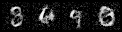

Epoch 25

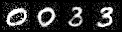

Epoch 50

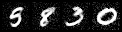


Epoch 75

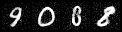


Epoch 100

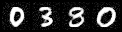

**Question 4.2.1:** *Which generates more realistic images: your GAN, or your VAE? Why do you think this is?*

**Answer:** Looking at the first 20 images generated by the GAN, I believe that my GAN generates more realistic images than the VAE. This is likely due to several factors. First, the GAN is explicitly trained to generate images using a sample from a specified distribution (i.e. `randn()`) whereas the VAE is simply a modification of an autoencoder that is meant to encourage a latent space that is better for interpolating and generating images with. Second, because the GAN has a discriminator, the adversarial training (i.e. alternating between generator and discriminator) is proven to be a powerful technique to generate realistic images because as the discriminator gets better through training, the generator continues to get better as a result. While the quality of the GAN images is pretty good and looks like realisitic digits (e.g. the images generated from epoch 100 look as though they could have come from the MNIST dataset), there is still an issue of mode collapse (which I will discuss below).

**Question 4.2.2:** *Does your GAN appear to generate all digits in equal number, or has it specialized in a smaller number of digits? If so, why might this be?*

**Answer:** No, the GAN does not generate all digits in equal number. Looking at the counts of each number generated+classified above, the GAN appears to have specialized in zeros, threes, and eights. Looking at the example images generated for each number, it is clear that the quality of a generated image is proportional to how frequently the generator outputs that number (e.g. the generated images of 0, 3, and 8 while the images of the rarer 1, 7, 4 barely look like digits). This makes sense given that the goal of a generator is simply to trick the discriminator into thinking that the generated image looks realistic, which it can do without generating a diverse array of numbers. It makes sense that the GAN would thus specialize in only a few numbers (0, 3, and 8), as those three numbers have relatively similar curvy shapes, and have quite poor performance on the other numbers which have more sharp edges.

The issue here is mode collapse. If we wanted equal distribution, we would likely need some kind of penalty (e.g. batch level penalty to ensure that a batch of generated images are representative of the train set) or a modified architecture that can explicitly generate specific numbers (e.g. a conditional GAN with the label as the condition).


## 5 Information Theory

### 5.1 Simple Distribution

In [ ]:
import numpy as np
import time
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import cv2

# !pip install pyemd
from pyemd import emd
from scipy.spatial.distance import cdist

for var in [0.5, 1, 2, 4]:
    print("Variance:", var)

    samples_normal = np.random.multivariate_normal((0, 0, 0), var*np.identity(3), 1000)
    min_n, max_n = np.min(samples_normal), np.max(samples_normal)
    samples_unif = np.random.uniform(low = min_n, high = max_n, size = (1000, 3))

    space = np.linspace(-1, 1, 10)
    random_space_samples = np.dstack(np.meshgrid(space, space, space)).reshape(-1, 3)
    shifted_space_samples = random_space_samples - random_space_samples.min()


    begin = time.perf_counter()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
    probs_unif = np.exp(kde.score_samples(random_space_samples))

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
    probs_normal = np.exp(kde.score_samples(random_space_samples))

    dist = entropy(probs_unif, probs_normal)

    print(f" - KL Divergence 1: dist = {dist} && time = {time.perf_counter() - begin}")


    begin = time.perf_counter()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
    probs_unif = np.exp(kde.score_samples(random_space_samples))

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
    probs_normal = np.exp(kde.score_samples(random_space_samples))

    dist = entropy(probs_normal, probs_unif)

    print(f" - KL Divergence 2: dist = {dist} && time = {time.perf_counter() - begin}")


    begin = time.perf_counter()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
    probs_unif = np.exp(kde.score_samples(random_space_samples))

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
    probs_normal = np.exp(kde.score_samples(random_space_samples))

    distance_matrix = cdist(random_space_samples, random_space_samples)
    dist = emd(probs_unif, probs_normal, distance_matrix)

    print(f" - EMD: dist = {dist} && time = {time.perf_counter() - begin}")


    begin = time.perf_counter()

    dist = mmd(samples_unif, samples_normal, kernel_fn = kernel)

    print(f" - MMD: dist = {dist} && time = {time.perf_counter() - begin}")

Variance: 0.5
 - KL Divergence 1: dist = 0.258304946752189 && time = 0.19394392799949856
 - KL Divergence 2: dist = 0.21459195938445644 && time = 0.19525240900111385
 - EMD: dist = 152.60533235341643 && time = 0.3142940899997484
 - MMD: dist = 0.07468240037069765 && time = 0.0819102280001971
Variance: 1
 - KL Divergence 1: dist = 0.08426598210110925 && time = 0.18489393799973186
 - KL Divergence 2: dist = 0.0783663453192735 && time = 0.19153332300084003
 - EMD: dist = 96.34728147453409 && time = 0.3185965090015088
 - MMD: dist = 0.03155829275546884 && time = 0.07261790899974585
Variance: 2
 - KL Divergence 1: dist = 0.03971532596440337 && time = 0.17847321099907276
 - KL Divergence 2: dist = 0.04135924563343334 && time = 0.18091042500054755
 - EMD: dist = 51.470351726218794 && time = 0.30734841499906906
 - MMD: dist = 0.012097997073582705 && time = 0.07397601100092288
Variance: 4
 - KL Divergence 1: dist = 0.11274511295365536 && time = 0.17200355299974035
 - KL Divergence 2: dist = 0.1

**Question 5.1.1:** *Based on the above measures alone, which divergence seems most accurate?*

**Answer:** Based on the above measures alone, it appears that either EMD or MMD is the most accurate divergence. In addition, KL divergence is the least accurate. Even as the variance increases and the normal distribution approaches a flatter uniform distribution, the KL-divergence does not decrease as it should based on the shape of the uniform distribution. In general, KL-divergence suffers from not taking into account the space of the distribution and how severe the displacement of one probability distribution is from the other (e.g. how much "earth" to move like with EMD). On the other hand, both EMD and MMD scale down as the variance increases. This makes more sense as both EMD and MMD take into consideration the metric space and thus appropriately scale as the variance increases and the distributions look more alike. Therefore, I would say EMD and MMD are the most accurate; however, MMD was much faster because we didn't have to explicitly estimate and sample the probability distribution space as I did for KL-divergence and EMD.

### 5.2 MNIST Sample Distributions

In [ ]:
mnist_1 = mnist_test.data[:1000, ]
mnist_2 = mnist_test.data[1000:2000, ]

mnist_1, mnist_2, _ = torch.utils.data.random_split(mnist_test, [1000, 1000, 8000])

loader_1 = torch.utils.data.DataLoader(mnist_1, 1000, shuffle = True)
loader_2 = torch.utils.data.DataLoader(mnist_2, 1000, shuffle = True)

for data, targets in loader_1:
    data_1_og = data.reshape(-1, 784).numpy()

for data, targets in loader_2:
    data_2_og = data.reshape(-1, 784).numpy()

# Tried 8 dimensions but cpu crashed b/c not enough RAM (Kincaid said it was okay)
torch.manual_seed(1)
nc = 4
data_1 = scprep.reduce.pca(data_1_og, n_components=nc)
data_2 = scprep.reduce.pca(data_2_og, n_components=nc)

min_1, max_1 = min(data_1.min(), data_2.min()), max(data_1.max(), data_2.max())
space = np.linspace(min_1, max_1, 6)
random_space_samples = np.dstack(np.meshgrid(*([space]*nc))).reshape(-1, nc)


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_2)
probs_2 = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_1, probs_2)

print(f" - KL Divergence 1: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_2)
probs_2 = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_2, probs_1)

print(f" - KL Divergence 2: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_2)
probs_2 = np.exp(kde.score_samples(random_space_samples))

distance_matrix = cdist(random_space_samples, random_space_samples)
dist = emd(probs_1, probs_2, distance_matrix)

print(f" - EMD: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

dist = mmd(data_1, data_2, kernel_fn = kernel)

print(f" - MMD: dist = {dist} && time = {time.perf_counter() - begin}")

 - KL Divergence 1: dist = 0.921103562013962 && time = 0.13204792499982432
 - KL Divergence 2: dist = 0.5977558921474413 && time = 0.1035623489997306
 - EMD: dist = 0.40034533621164475 && time = 0.8358239389999653
 - MMD: dist = 0.0015331105813092003 && time = 0.06550864099972387


### 5.3 The GAN Distribution

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Generator with nz=25
generator = torch.load('/content/drive/MyDrive/ColabNotebooks/gan_2.pt', map_location=torch.device('cpu'))
generator.eval()

# Modified from display_10 function above
torch.manual_seed(2)
fake_data = generator(torch.randn(1000, 100)).reshape(-1, 784).detach().numpy()

# Reduce Dimensions
fake_data = scprep.reduce.pca(fake_data, n_components=nc)
min_1, max_1 = min(data_1.min(), fake_data.min()), max(data_1.max(), fake_data.max())
space = np.linspace(min_1, max_1, 6)
random_space_samples = np.dstack(np.meshgrid(*([space]*nc))).reshape(-1, nc)


# Calculate divergences
begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(fake_data)
probs_2 = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_1, probs_2)

print(f" - KL Divergence 1: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(fake_data)
probs_2 = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_2, probs_1)

print(f" - KL Divergence 2: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(fake_data)
probs_2 = np.exp(kde.score_samples(random_space_samples))

distance_matrix = cdist(random_space_samples, random_space_samples)
dist = emd(probs_1, probs_2, distance_matrix)

print(f" - EMD: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

dist = mmd(data_1, fake_data, kernel_fn = kernel)

print(f" - MMD: dist = {dist} && time = {time.perf_counter() - begin}")

 - KL Divergence 1: dist = 1.163272109587778 && time = 0.13459601399972598
 - KL Divergence 2: dist = 7.700116586534358 && time = 0.09691876200031402
 - EMD: dist = 1.660057034892884 && time = 1.8326356039997336
 - MMD: dist = 0.002146157393922376 && time = 0.06719719400007307


**Question 5.3.1:** *Which divergence or distance showed the greatest discrepancy between the comparison between real MNIST data and the comparison with the GAN?*

**Answer:** All three divergence values increase when using the GAN distribution as opposed to using two samples from the MNIST data which is what I would expect, with KL divergence showing the greatest discrepancy (between the larger of the last two KL divergences and the smaller of the first two KL divergences). However because KL divergence is not symmetric, notice that the KL divergence using the MNIST data conditioned on the generated data leads to a significantly different value from the inverse (i.e. KL divergence of generated data conditioned on MNIST sample). Therefore, the KL divergence may be clueless in this context and not calculating a useful divergence when comparing these samples of digits. Between MMD and EMD, EMD estimates a rough 3x increase in the distance while MMD only estimates about 0.4x increase in the distance.

In addition all of the metrics could be slightly off because I had to use PCA to reduce the number of dimensions since we could not reasonably sample from a 784-dimensional space. Reducing the number of dimensions could thus explain some of the discrepancies in the metrics.

**Question 5.3.2:** *Which of these information measures would you recommend for judging a GAN’s output? Why?*

**Answer:** I would recommend using either EMD or MMD because from the two examples (uniform vs random and MNIST vs GAN) it appears that EMD and MMD are generally more robust metrics than KL divergence that accurately depict the dissimilarity/similarity between samples. In addition, note above that the asymmetry of KL divergence leads to very different results depending on which way the divergence is calculated. Additionally, I know that Wasserstein (EMD) GANs and MMD GANs exist and are widely used whereas KL divergence is not traditionally used with GANs because of the issues noted above.

**Question 5.3.3:** *How do the runtimes of these measures compare?*

**Answer:** In general, EMD took the longest time by far to calculate because it requires estimating the probability distributions, sampling those distributions, and calculating the distance matrix before passing these values into the `emd()` function from `pyemd` (which is not very fast). The next slowest was the KL divergence because it also required estimating and sampling the probability distribution before passing these into the `entropy()` function from `scipy.spatial.distance`. The fastest by far was the `mmd()` function we wrote because it does not require estimating or sampling the probability distribution, instead calculating the metric based on the data samples with a kernel function.

This order of runtimes applied for both the uniform/normal data and the digits.